# Urban Sound Prediction 
### using **CNN**
### Train/Test Accuracy : **99.80%**, **95.25%**

## Step 1 : Install required libraries

In [2]:
!pip install numpy pandas
!pip install matplotlib seaborn plotly
!pip install keras scikit-learn librosa tqdm opencv-python

## Step 2 : Import required libraries

In [3]:
# Basic Libraries
import os
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# Specific Libraries
import cv2
import librosa
import librosa.display
from typing import List, Tuple
from pathlib import Path
import IPython.display as ipd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from tqdm import tqdm, trange
from tqdm.auto import tqdm

from keras.utils import to_categorical
from keras import Sequential, layers
from keras.layers import Dense , Activation , Dropout

from itertools import cycle
# Retrieve the default color palette from Matplotlib
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a color cycle iterator from the default color palette
color_cycle = cycle(color_pal)  # Cycle will allow for looping through the colors

# Mount google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Warnings
import warnings
warnings.filterwarnings('ignore')

## Step 3 : Load and prepare the dataset

- ### Load the dataset

In [4]:
# Path the data
data_dir = '/kaggle/input/urbansound8k'

# Load the audio data
audio_csv_path = os.path.join(data_dir, 'UrbanSound8K.csv')
audio_df = pd.read_csv(audio_csv_path)
audio_df.info()
audio_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


slice_file_name    fsID     start        end  salience  fold  classID  \
1235  129750-2-0-3.wav  129750  1.500000   5.500000         2    10        2   
5296  203913-8-0-6.wav  203913  3.000000   7.000000         1     5        8   
8512  94636-8-0-11.wav   94636  5.500000   9.500000         2     3        8   
2127  151977-0-0-1.wav  151977  0.966587   4.966587         1     1        0   
5591  22601-8-0-12.wav   22601  6.000000  10.000000         2     3        8   

                 class  
1235  children_playing  
5296             siren  
8512             siren  
2127   air_conditioner  
5591             siren

- ### Extract Classes

In [5]:
classes = audio_df['class'].unique().tolist()
num_classes = len(classes)
print(f"> Number of Classes is : {num_classes}")
print(f"> Classes:\n {classes}")

> Number of Classes is : 10
> Classes:
 ['dog_bark', 'children_playing', 'car_horn', 'air_conditioner', 'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer', 'drilling']


- ### Extracts audio files

In [6]:
def extract_audio_files(dir_path: str) -> List[Path]:
    """Extracts and returns a list of .wav audio files from the specified directory."""
    # Create a Path object
    directory = Path(dir_path)
    
    # Use the Path object to find all .wav files in the specified directory and subdirectories
    return list(directory.rglob('*.wav'))

In [7]:
audio_files = extract_audio_files(data_dir)
print(f'> {len(audio_files)} audio files found in {data_dir}')
audio_files[:5]

> 8732 audio files found in /kaggle/input/urbansound8k


[PosixPath('/kaggle/input/urbansound8k/fold7/164797-2-0-8.wav'),
 PosixPath('/kaggle/input/urbansound8k/fold7/177537-7-2-0.wav'),
 PosixPath('/kaggle/input/urbansound8k/fold7/177729-0-0-68.wav'),
 PosixPath('/kaggle/input/urbansound8k/fold7/6902-2-0-18.wav'),
 PosixPath('/kaggle/input/urbansound8k/fold7/518-4-0-2.wav')]

## Step 4 : Exploratory Data Analysis (EDA)

- ### Number of audios in each class

In [8]:
# Create a DataFrame with class counts
labels = (audio_df['class'].value_counts().reset_index())

# Rename the columns
labels.columns = ['Class', 'Count']

# Format the Class names
labels['Class'] = labels['Class'].str.replace('_', ' ').str.capitalize()

# Sort by Count in descending order
labels.sort_values(by='Count', ascending=False, inplace=True)

# Create a Plotly bar chart
fig = px.bar(
    labels, x='Class', y='Count', title='Count of Classes', hover_data=['Class', 'Count'], color='Count')

# Customize the layout
fig.update_layout(xaxis_title='Class', yaxis_title='Count', xaxis_tickangle=-90)

# Show the figure
fig.show()

- ### Play audio file

In [9]:
def play_audio_file(file_path: str) -> tuple:
    """Plays the audio file if it exists and is a .wav file, and returns sample data and rate."""
    # Create a Path object
    file = Path(file_path)
    
    # Check if the file exists and has .wav extension
    if file.is_file() and file.suffix.lower() == '.wav':
        # Load the audio file, preserving its original sample rate
        sample, sample_rate = librosa.load(file_path, sr=None)
        
        # Display audio playback controls and log sample info
        print(f">> Playing audio from {file_path}")
        print(f">  Sample Rate : {sample_rate} Hz")
        
        # Return the Audio object for playback
        return ipd.Audio(sample, rate=sample_rate), sample, sample_rate
    else:
        print(f"{file_path} does not exist or is not a .wav file.")
        return None, None, None

In [10]:
audio_widget, sample, rate = play_audio_file(audio_files[0])
audio_widget

>> Playing audio from /kaggle/input/urbansound8k/fold7/164797-2-0-8.wav
>  Sample Rate : 48000 Hz


- ### Display audio file

In [11]:
def visualize_audio(file_path: str, color_pal: list = ['blue', 'orange', 'red']) -> None:
    """Load a .wav audio file and display its raw audio waveform, spectrogram, and MFCCs in one figure."""
    # Create a Path object
    file = Path(file_path)
    
    # Check if the file exists and has a .wav extension
    if not file.is_file() or file.suffix.lower() != '.wav':
        return ValueError(f"{file_path} does not exist or is not a .wav file.")
    
    # Load the audio file
    sample, sample_rate = librosa.load(file_path, sr=None)  # Use sr=None to preserve original sampling rate

    # Create figure with three subplots
    n_plots = 2
    fig, axs = plt.subplots(n_plots, 1, figsize=(16, n_plots * 4))

    # Plot the Waveform of audio
    librosa.display.waveshow(sample, sr=sample_rate, ax=axs[0], color=color_pal[0])
    axs[0].set_title("Waveform of Audio")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")

    # Compute Short-Time Fourier Transform (STFT)
    D = librosa.stft(sample)
    # Convert amplitude to decibels
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Plot the spectrogram of audio 
    spect_img = librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='log', ax=axs[1])
    axs[1].set_title("Spectrogram (dB)")
    plt.colorbar(spect_img, ax=axs[1], format='%+2.0f dB')
    axs[1].set_ylabel("Frequency")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

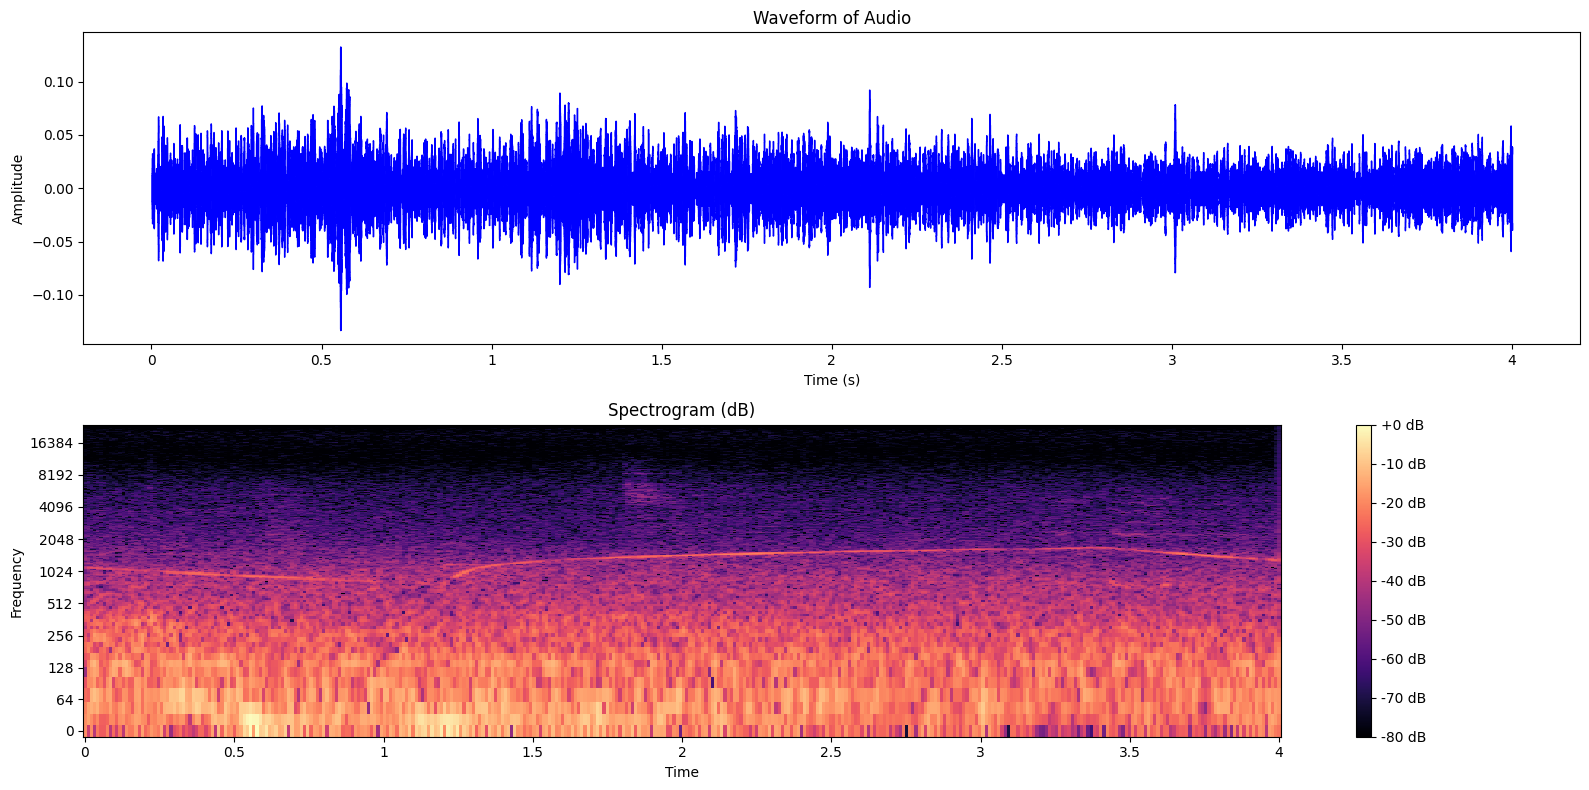

In [12]:
# display_audio usage:
visualize_audio(audio_files[0])

- ### Display audio files of each class

>>>> Audio of Air conditioner :


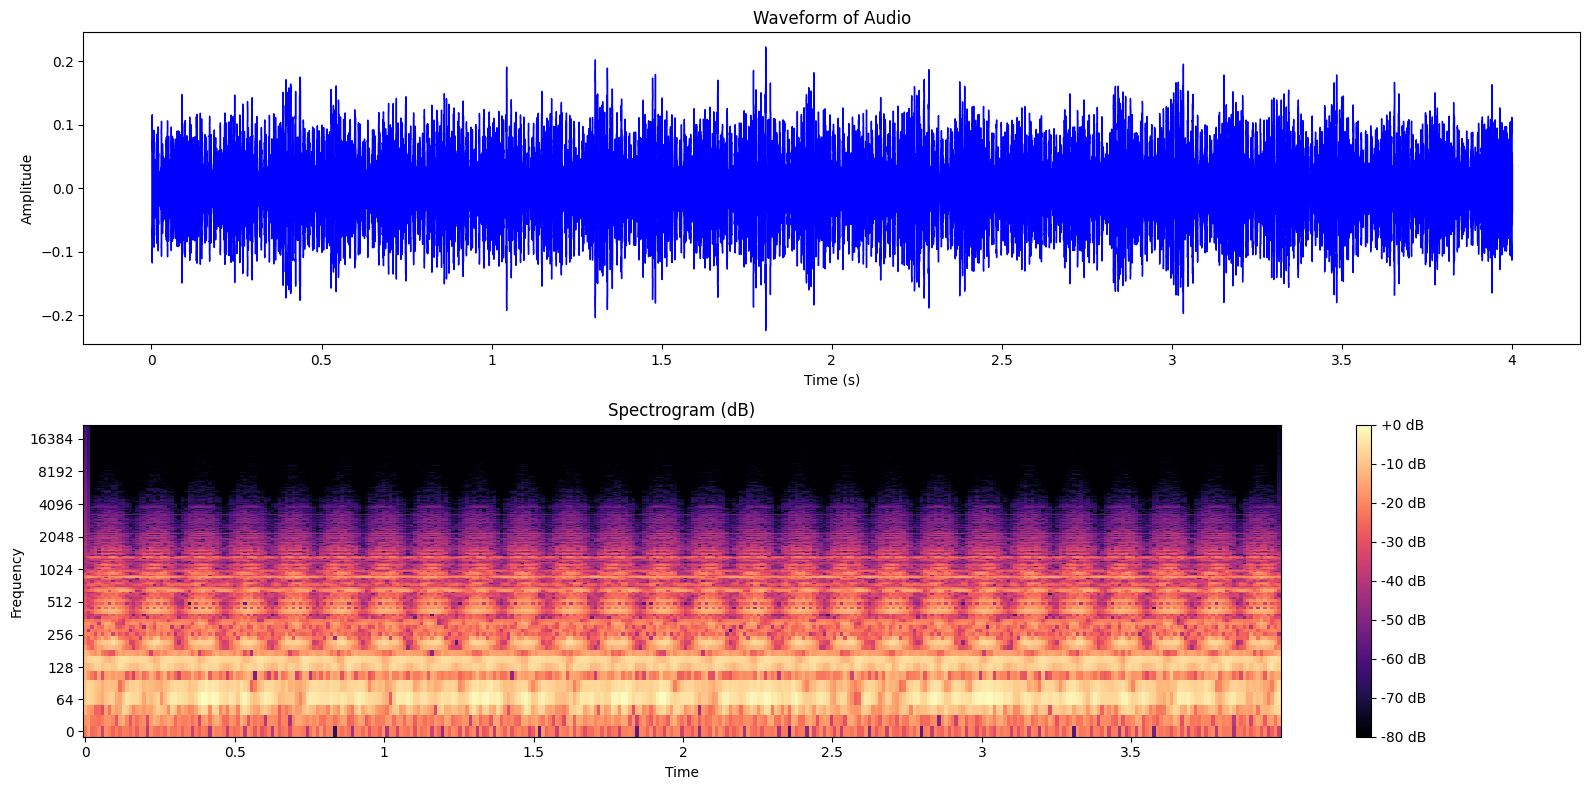

>>>> Audio of Car horn :


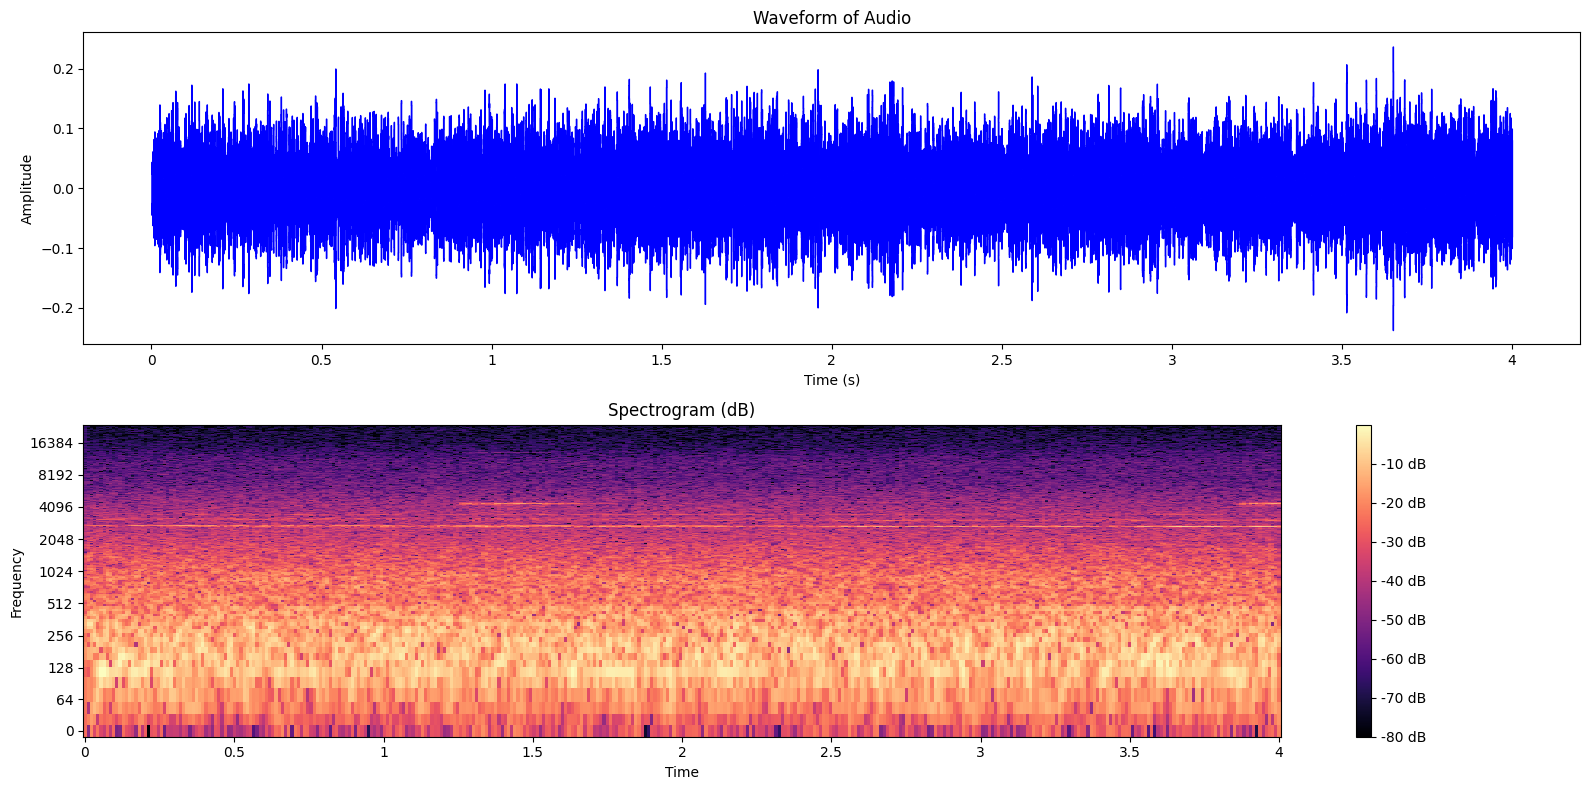

>>>> Audio of Children playing :


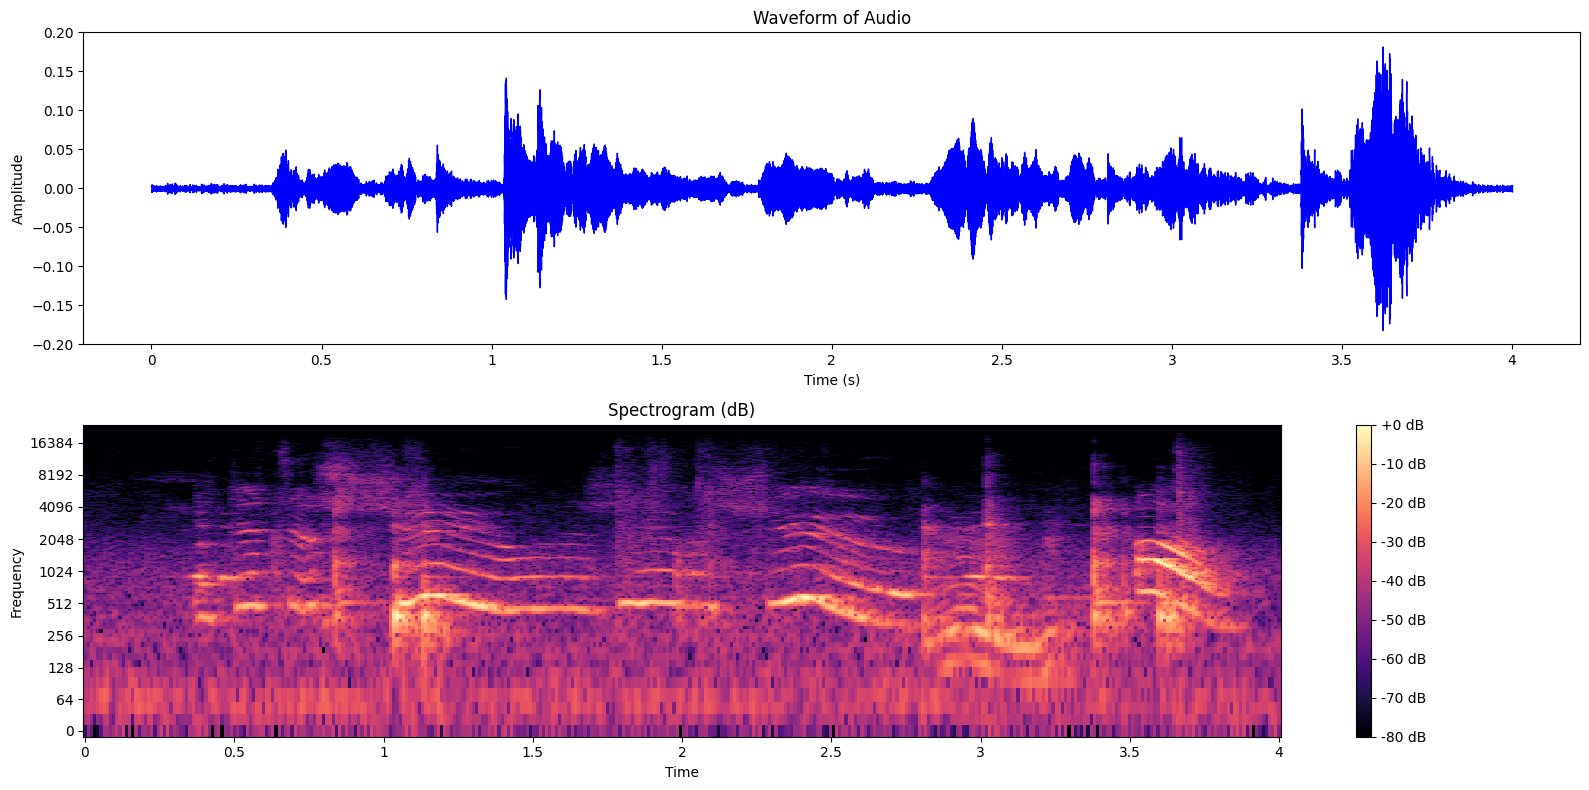

>>>> Audio of Dog bark :


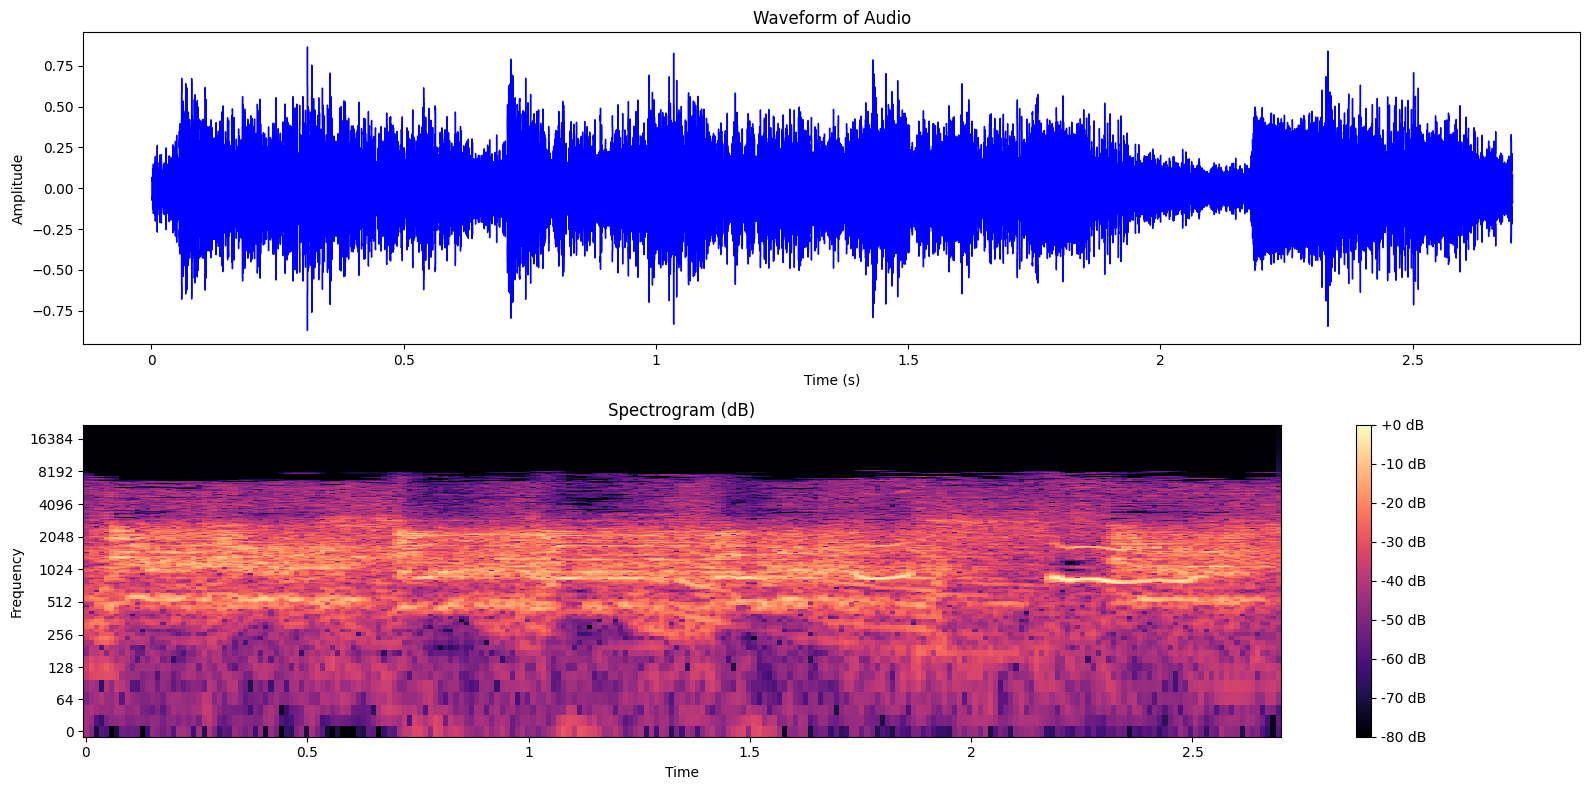

>>>> Audio of Drilling :


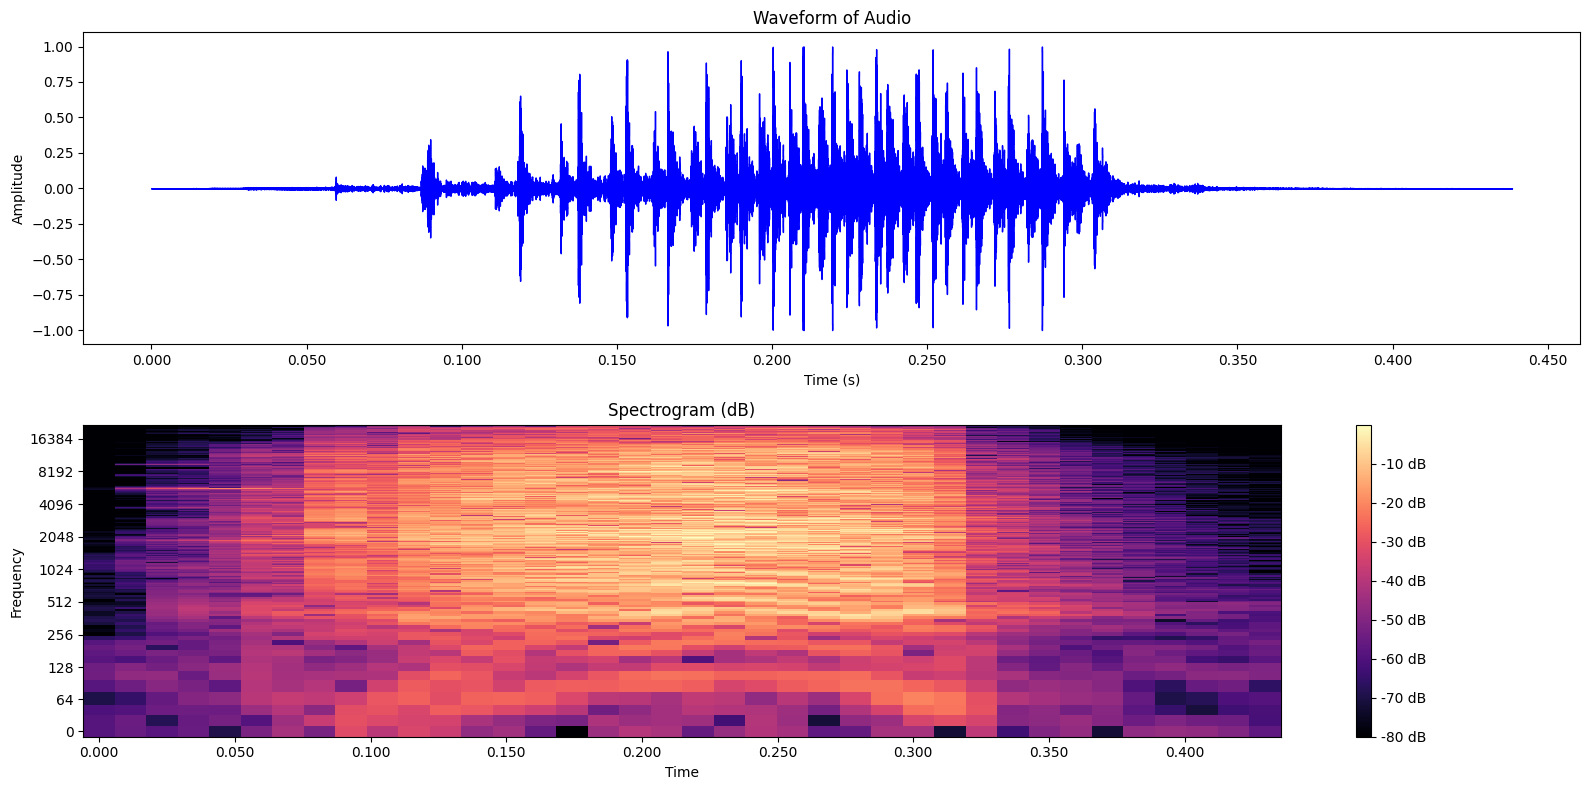

>>>> Audio of Engine idling :


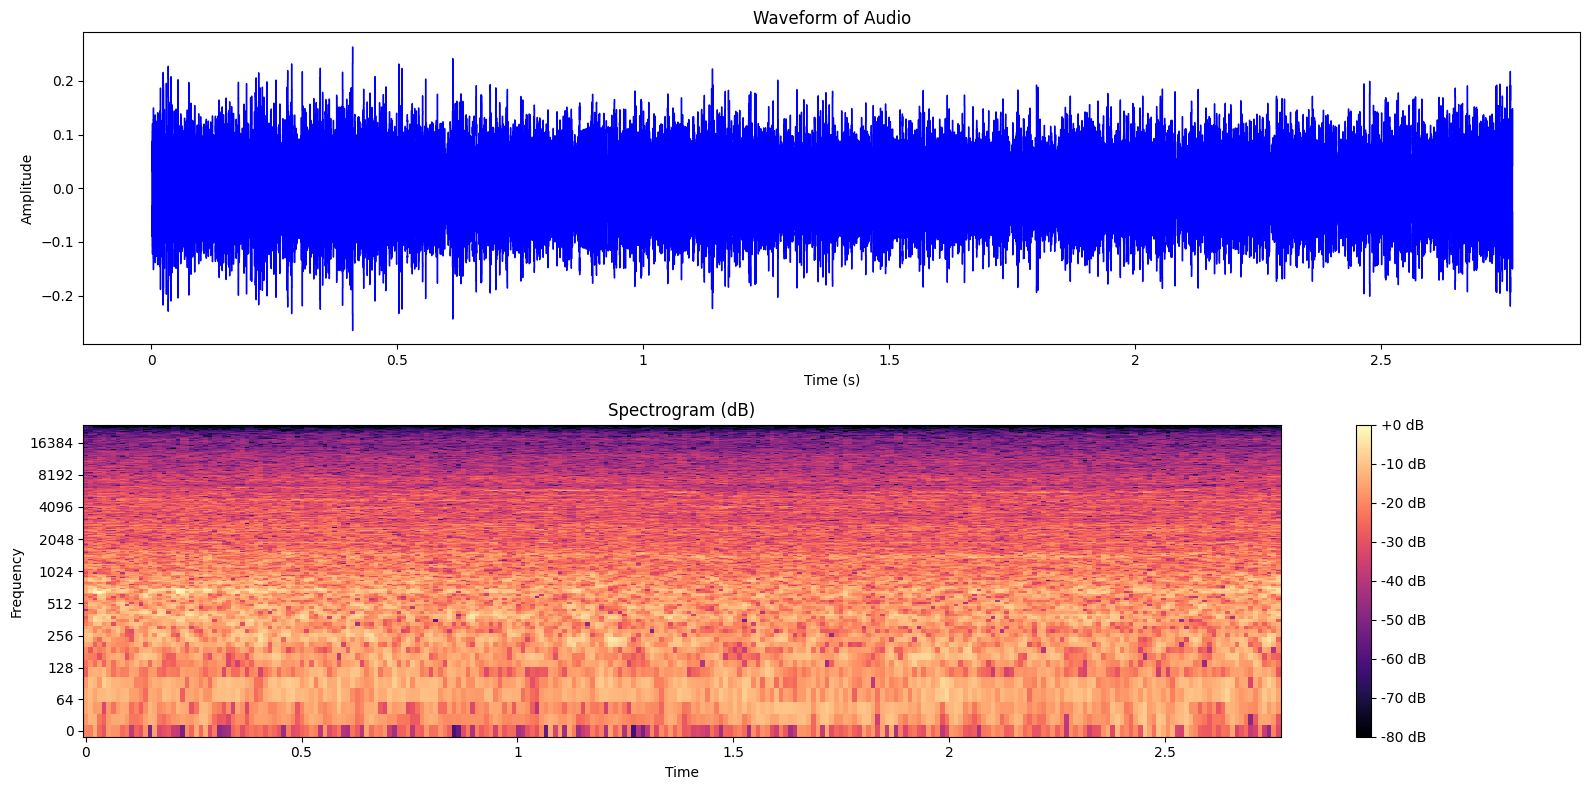

>>>> Audio of Gun shot :


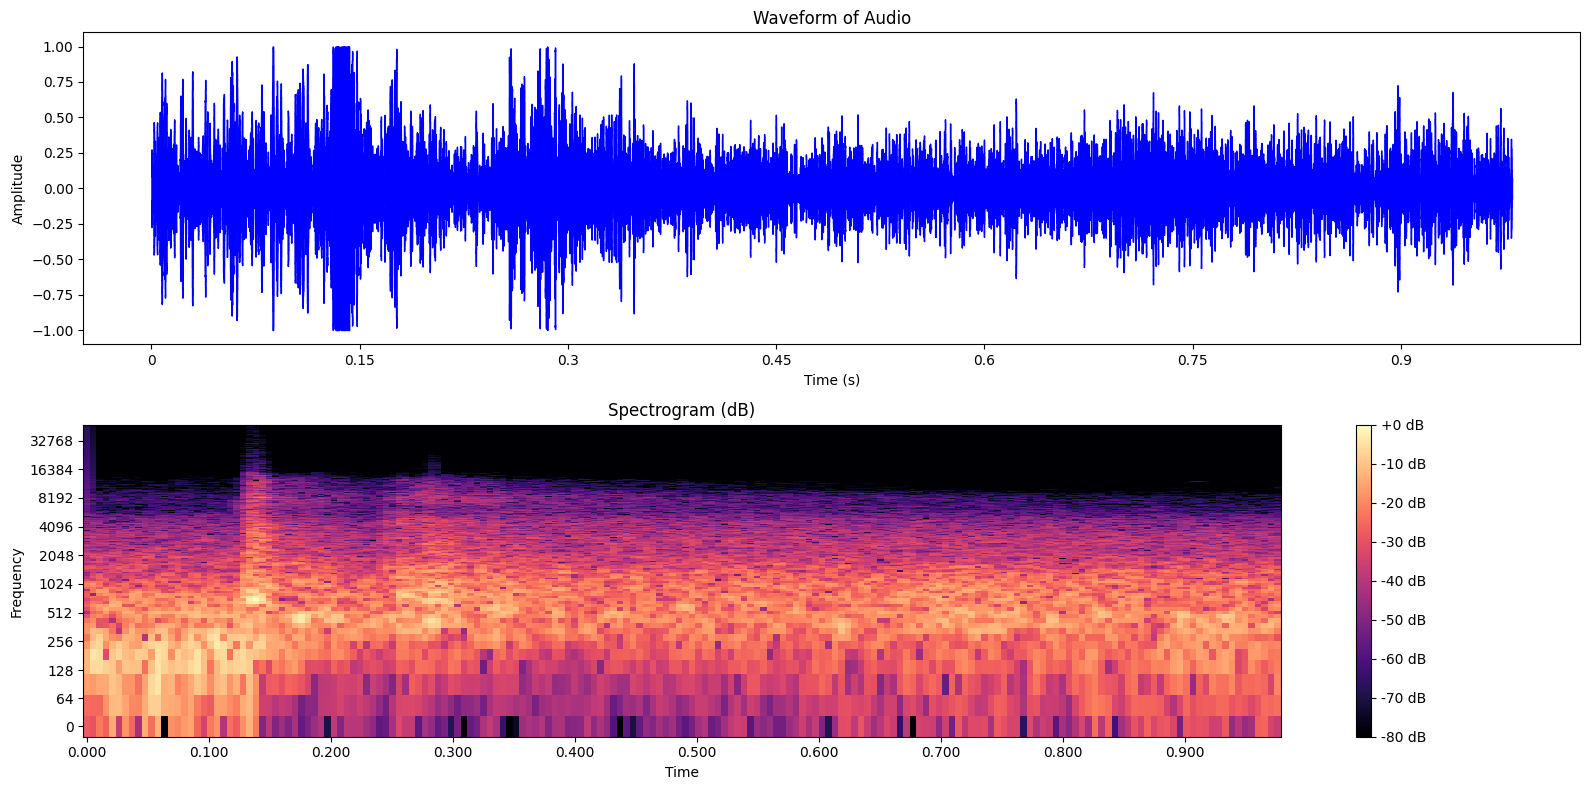

>>>> Audio of Jackhammer :


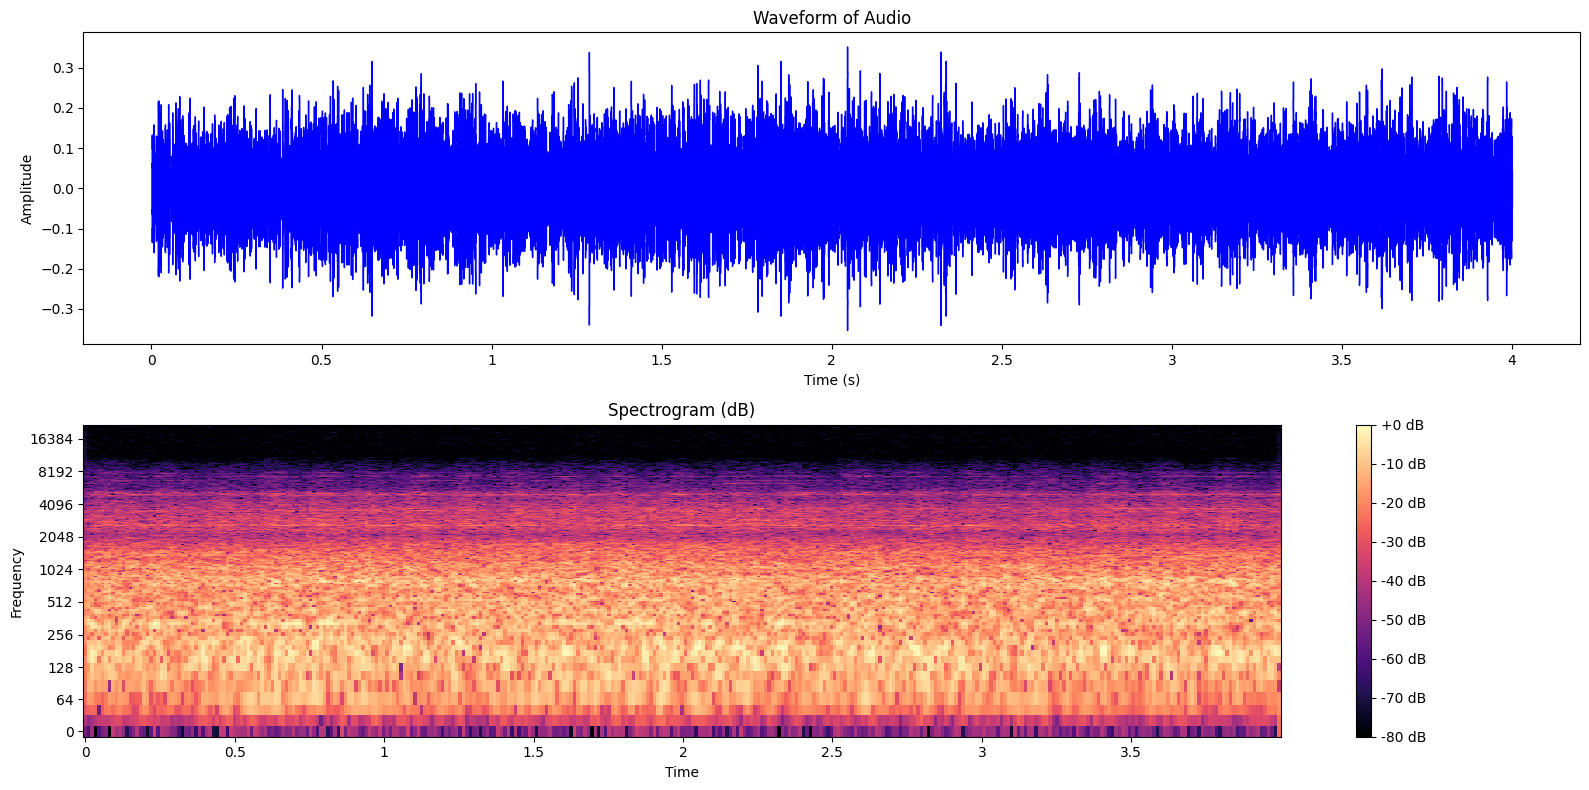

>>>> Audio of Siren :


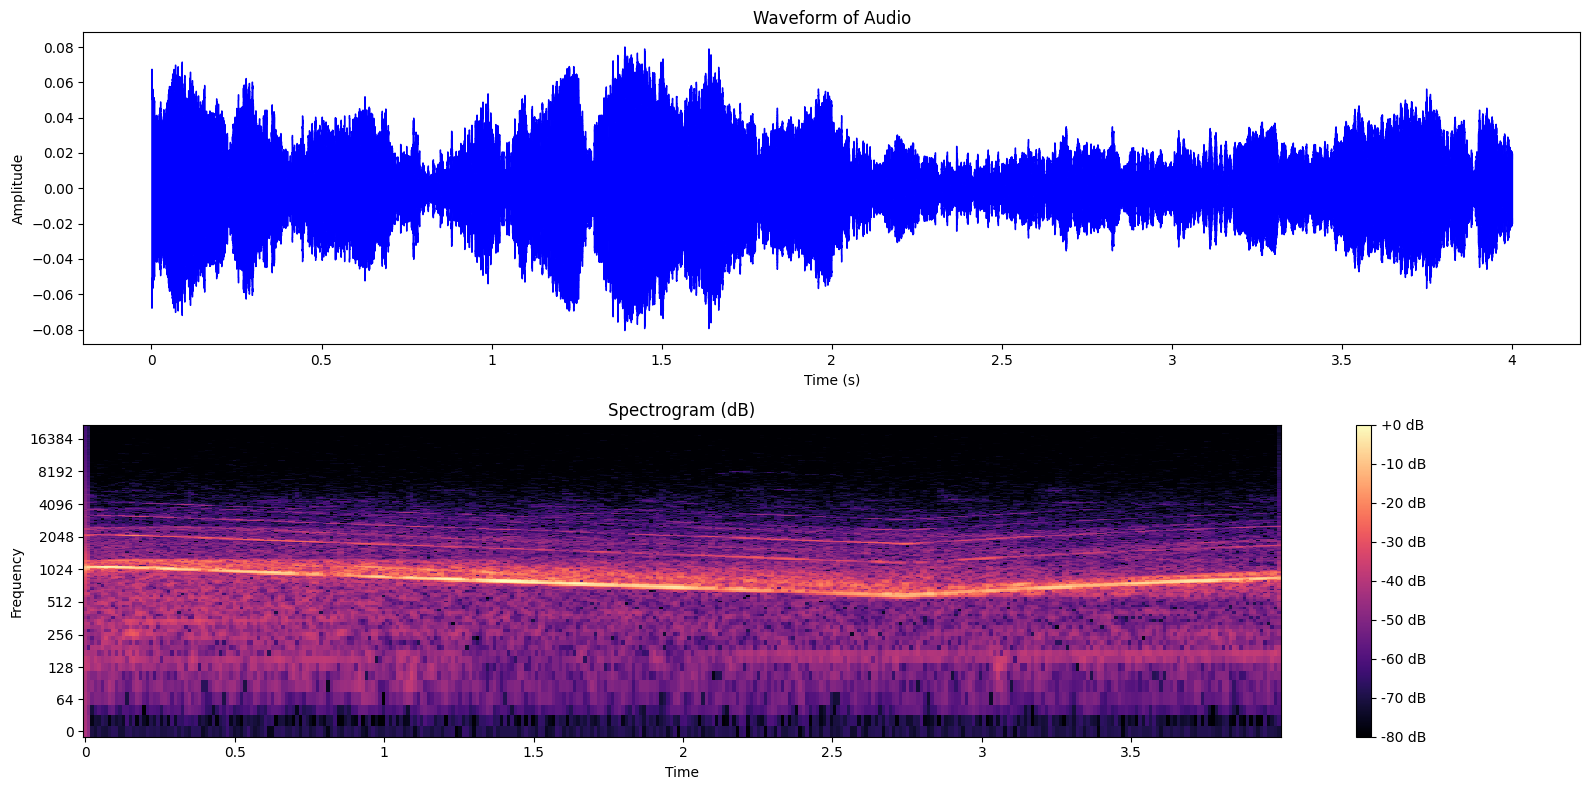

>>>> Audio of Street music :


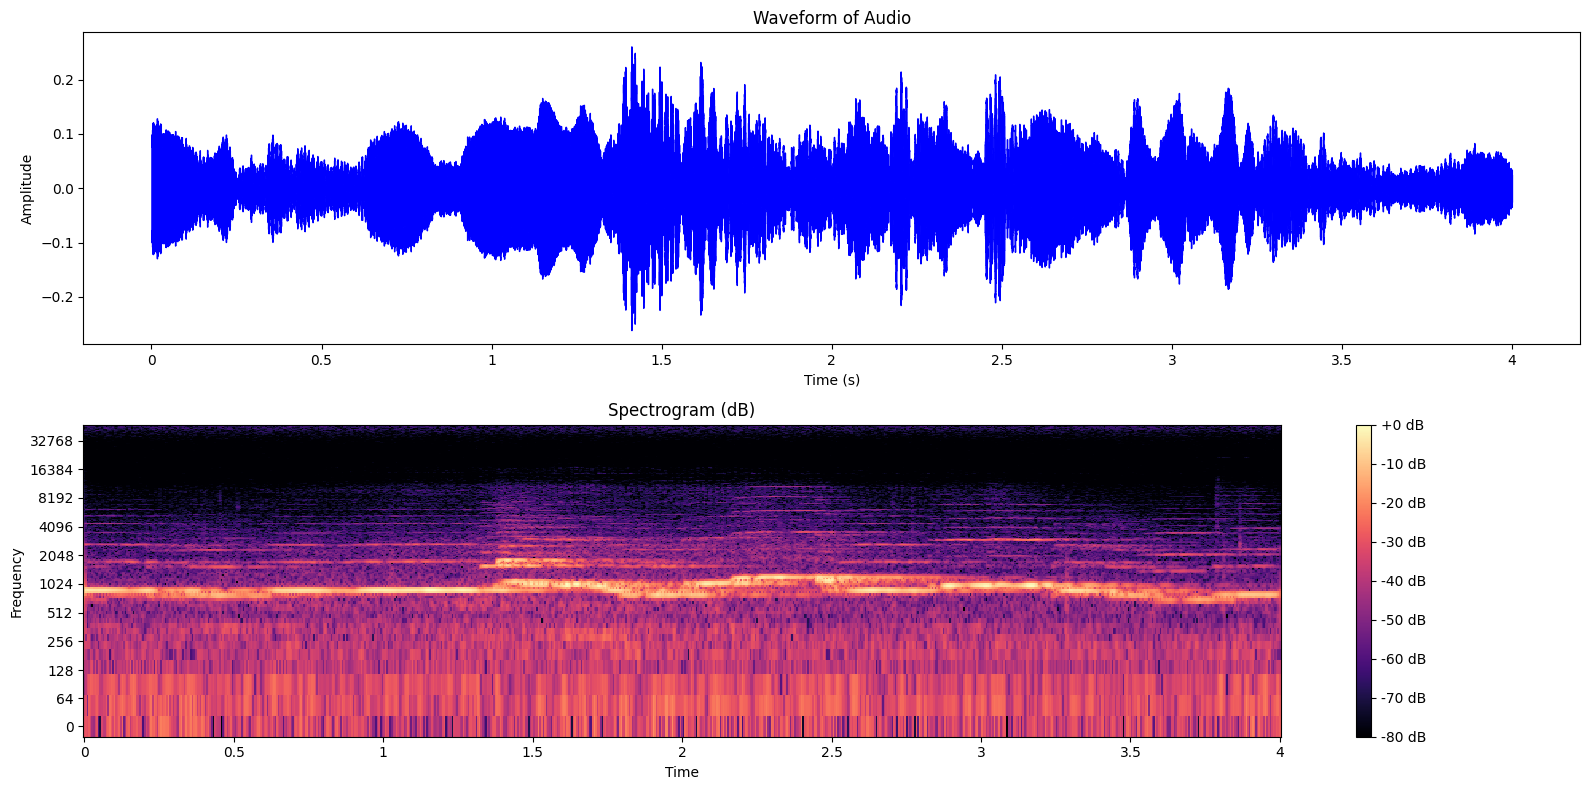

In [13]:
# Extract a sample from each class
random_samples_df = audio_df.groupby(by='class').sample(1)
random_samples_df = random_samples_df[['slice_file_name', 'fold', 'class']]

# Display the spectrogram of each class
for index, row in random_samples_df.iterrows():
    class_name = row['class'].replace('_', ' ').capitalize()
    file_path = os.path.join(data_dir, f'fold{row.fold}/{row.slice_file_name}')
    print(f'>>>> Audio of {class_name} :')
    visualize_audio(file_path)

## Step 5 : Load and Preprocess data

- ### Extract MFCC features

In [14]:
import os
import numpy as np
import librosa
import cv2
import pandas as pd

def extract_mfcc_features(data_dir, df, up_width=173, up_height=40, n_mfcc=50):
    """Extract MFCC features from audio files listed in the dataframe."""
    mfcc_features = []
    labels = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing audio files'):
        file_name = os.path.join(data_dir, f'fold{row.fold}', row.slice_file_name)
        
        # Load audio file
        sample, sample_rate = librosa.load(file_name, sr=None, res_type='kaiser_fast')
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=n_mfcc)
        
        # Resize MFCC to the specified dimensions
        resized_mfcc = cv2.resize(mfcc, (up_width, up_height), interpolation=cv2.INTER_LINEAR)
        
        # Append results to lists
        mfcc_features.append(resized_mfcc)
        labels.append(row['class'])
    
    # Convert lists to numpy arrays
    return np.array(mfcc_features), np.array(labels)

In [15]:
up_width = 173
up_height = 40
n_mfcc = 50

X, y = extract_mfcc_features(data_dir, audio_df, up_width, up_height, n_mfcc)
print(f'> Shape of MFCC features  (X) : {X.shape}')
print(f'> Shape of Labels         (y) : {y.shape}')

Processing audio files:   0%|          | 0/8732 [00:00<?, ?it/s]

> Shape of MFCC features  (X) : (8732, 40, 173)
> Shape of Labels         (y) : (8732,)


- ### Label encoding and features reshaping

In [16]:
# Label encoding
le = LabelEncoder()
encoded_y = to_categorical(le.fit_transform(y))
# Features reshaping
reshaped_X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

print(f'> Shape of Features       : {reshaped_X.shape}')
print(f'> Shape of Encoded Labels : {encoded_y.shape}')

> Shape of Features       : (8732, 40, 173, 1)
> Shape of Encoded Labels : (8732, 10)


## Step 6 : Split data into training and testing sets

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_X, encoded_y, test_size=0.2, random_state=123)
print(f'> Shape of Train Features : {X_train.shape}')
print(f'> Shape of Train Label    : {y_train.shape}')
print(f'> Shape of Test  Features : {X_test.shape}')
print(f'> Shape of Test  Label    : {y_test.shape}')

> Shape of Train Features : (6985, 40, 173, 1)
> Shape of Train Label    : (6985, 10)
> Shape of Test  Features : (1747, 40, 173, 1)
> Shape of Test  Label    : (1747, 10)


## Step 7 : Train a CNN model

- ### Create and compile a CNN model

In [18]:
from keras import Sequential, layers, optimizers

def create_cnn_model(input_shape, num_classes=10, learning_rate=0.001, dropout_rate=0.3):
    """Create and compile a CNN model."""
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=input_shape),
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='valid'),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(dropout_rate),
        layers.Conv2D(128, (3, 3), activation='relu', padding='valid'),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(dropout_rate),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Print model summary
    model.summary()

    return model

In [19]:
# Assume input_shape is defined as per your input data, e.g. (height, width, channels)
input_shape = X_train.shape[1:]  # Example for grayscale images
learning_rate=0.001
dropout_rate=0.3

# Create a CNN model
cnn_model = create_cnn_model(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.3)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 171, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 84, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 42, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 42, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 40, 128)          │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,490 (861.29 KB)

 Trainable params: 220,490 (861.29 KB)

 Non-trainable params: 0 (0.00 B)

- ### Fit the CNN model

In [20]:
# Parameters
epochs = 100 
batch_size = 32

# Train the CNN model
cnn_history = cnn_model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test))

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 62s 274ms/step - accuracy: 0.3385 - loss: 1.9053 - val_accuracy: 0.5936 - val_loss: 1.1962
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 270ms/step - accuracy: 0.6003 - loss: 1.1338 - val_accuracy: 0.6497 - val_loss: 1.0250
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.6865 - loss: 0.8981 - val_accuracy: 0.7293 - val_loss: 0.8025
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 269ms/step - accuracy: 0.7713 - loss: 0.6836 - val_accuracy: 0.7865 - val_loss: 0.6317
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 271ms/step - accuracy: 0.8202 - loss: 0.5361 - val_accuracy: 0.8317 - val_loss: 0.5110
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 270ms/step - accuracy: 0.8541 - loss: 0.4208 - val_accuracy: 0.8420 - val_loss: 0.4643
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 61s 277ms/step - accuracy: 0.8718 - loss: 0.3986 - val_accuracy: 0.8580 - val_loss: 0.4415
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 271ms/step - accuracy: 0.8968 -

- ### Visualize the training history of CNN model

In [21]:
def plot_history(history=None, model_name: str = None, figure_directory: str = None, ylim_pad=[0, 0], figsize=(10, 10), show_grid=True):
    """Plot the training history of loss and R2 score with dual y-axes."""

    if history is None:
        raise ValueError(f"The {model_name}-history object must be provided.")

    x_labels = 'Epoch'

    # Creating a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=figsize)

    metrics = ['loss', 'accuracy']
    titles = ['Train', 'Validation']

    for i, title in enumerate(titles):
        # Prepare data
        y1 = history.history[metrics[0]] if title == 'Train' else history.history['val_loss']
        y2 = history.history[metrics[1]] if title == 'Train' else history.history['val_accuracy']

        ax1 = axs[i]
        
        # Plotting the loss
        ax1.plot(y1, label=f'{title} Loss', color='tab:blue')
        ax1.set_xlabel(x_labels)
        ax1.set_ylabel('Loss', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.set_title(f'{title} Loss and Accuracy per Epoch')
        ax1.legend(loc='lower left')
        
        # Create a second y-axis for the R² score
        ax2 = ax1.twinx()
        ax2.plot(y2, label=f'{title} Accuracy', color='tab:red')
        ax2.set_ylabel('Accuracy', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper left')

        # Optional ylim padding
        if ylim_pad:
            ax1.set_ylim([min(y1) - ylim_pad[0], max(y1) + ylim_pad[1]])
            ax2.set_ylim([min(y2) - ylim_pad[0], max(y2) + ylim_pad[1]])

        if show_grid:
            ax1.grid()

    fig.tight_layout()  # Adjust subplots to fit into figure area.

    if figure_directory:
        plt.savefig(f"{figure_directory}/{model_name}_training_history.png")  # Save to directory

    plt.show()

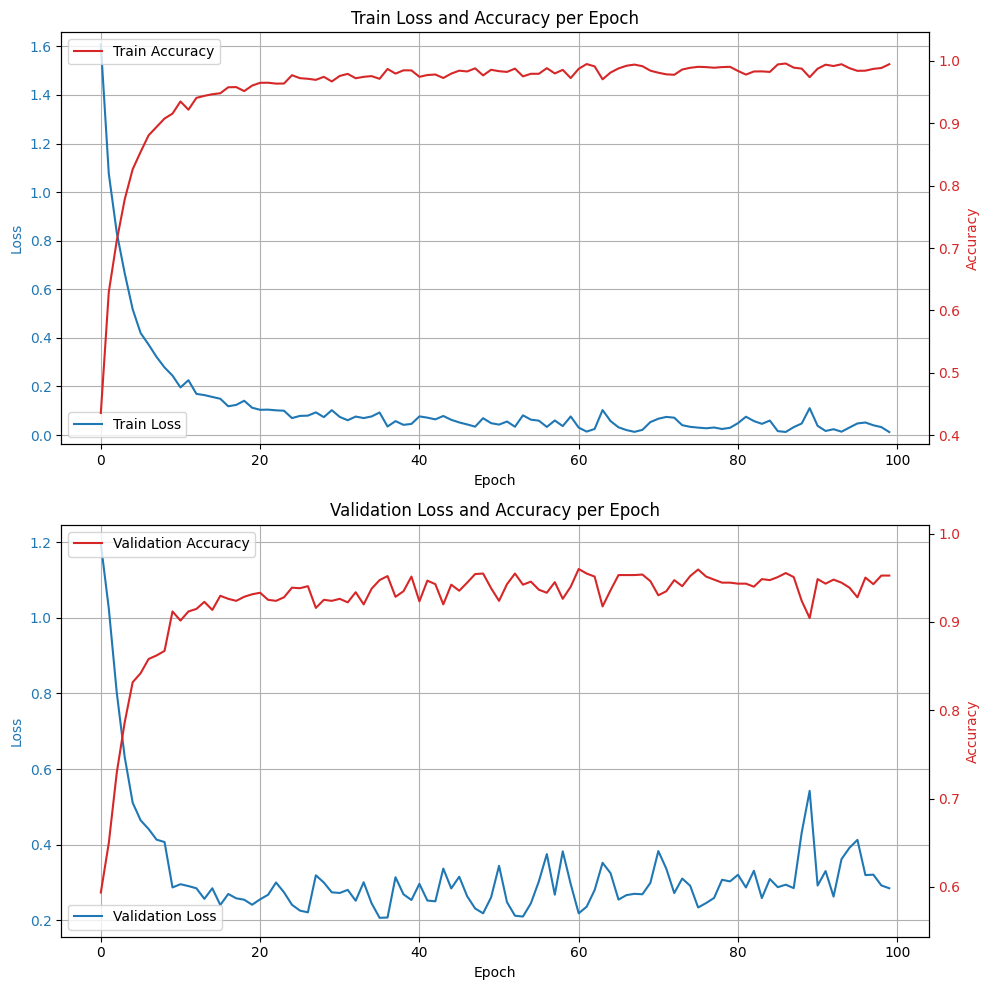

In [22]:
figure_dir = '/kaggle/working/'
model_name = 'CNN'

plot_history(history=cnn_history, model_name=model_name, figure_directory=figure_dir, ylim_pad=[0.05, 0.05], figsize=(10, 10))

## Step 8 : Evaluate the CNN model

In [23]:
def evaluate_model(model, X_train, y_train, X_test, y_test, encoder):
    """Evaluates the performance of the model on training and testing data."""
    # Evaluate the model on training and testing data
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    # Print evaluation results
    print('>> Evaluation ')
    print(f'>  Train Loss     : {train_loss:.4f}')
    print(f'>  Train Accuracy : {train_acc * 100:.2f}%')
    print(f'>  Test  Loss     : {test_loss:.4f}')
    print(f'>  Test  Accuracy : {test_acc * 100:.2f}%')
    
    # Predict the labels for test data
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in y_pred]
    y_test = [np.argmax(i) for i in y_test]

    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)  # Get the predicted class labels
    # y_test = np.argmax(y_test, axis=1)  # Get the actual class labels
    
    # Generate classification report
    test_report = classification_report(y_test, y_pred)
    print(f'>  Classification Report:\n{test_report}')

    # Plotting confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize = (12, 6))
    sns.heatmap(matrix, annot = True, cbar = False, fmt = 'd', cmap = 'Blues', xticklabels = encoder.classes_, yticklabels = encoder.classes_)
    plt.title('Confusion Matrix', fontsize = 16)
    plt.xlabel('Predicted Class', fontsize = 14)
    plt.xticks(rotation = 30)
    plt.ylabel('Actual Class', fontsize = 14)
    plt.show()

>> Evaluation 
>  Train Loss     : 0.0039
>  Train Accuracy : 99.80%
>  Test  Loss     : 0.2847
>  Test  Accuracy : 95.25%
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step
>  Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       186
           1       0.97      0.92      0.94        90
           2       0.92      0.93      0.92       202
           3       0.92      0.95      0.93       206
           4       0.94      0.94      0.94       192
           5       0.98      0.98      0.98       202
           6       0.95      0.98      0.96        81
           7       0.97      0.96      0.96       194
           8       0.97      0.99      0.98       185
           9       0.95      0.90      0.92       209

    accuracy                           0.95      1747
   macro avg       0.95      0.95      0.95      1747
weighted avg       0.95      0.95      0.95      1747



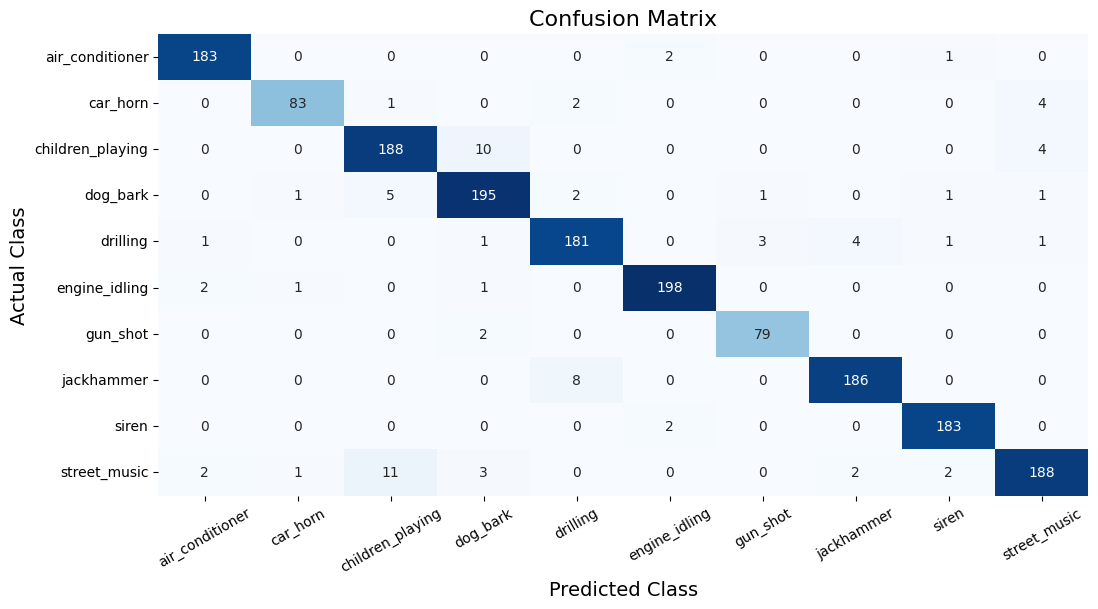

In [24]:
evaluate_model(cnn_model, X_train, y_train, X_test, y_test, le)

## Step 9 : Visualize predictions

In [59]:
def label_prediction(model: Sequential, encoder: LabelEncoder, file_name: str, n_mfcc: int=50, up_width: int=40, up_height: int=173) -> str:
    """Predict the class of an audio file using a trained model and decode the prediction."""
    try:
        # Load audio file
        sample, sample_rate = librosa.load(file_name, sr=None, res_type='kaiser_fast')

        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=n_mfcc)

        # Resize MFCC to the specified dimensions
        resized_mfcc = cv2.resize(mfcc_features, (up_width, up_height), interpolation=cv2.INTER_LINEAR)

        # Convert lists to numpy arrays
        resized_mfcc = np.array(resized_mfcc)
        
        # Features reshaping
        reshaped_mfcc = resized_mfcc.reshape(1, resized_mfcc.shape[0], resized_mfcc.shape[1], 1)
        
        # Predict label from the arrays of mfccs
        class_pred = model.predict([reshaped_mfcc]) 
        
        # Convert to integer and decode the class label
        class_pred_decoded = encoder.inverse_transform([np.argmax(class_pred[0])])[0]

        print(f'> The predicted class of audio is : {class_pred_decoded}')
        return class_pred_decoded

    except librosa.Error as e:
        raise RuntimeError(f"An error occurred during audio loading: {str(e)}")
    except ValueError as e:
        raise RuntimeError(f"An error occurred during feature extraction: {str(e)}")
    except Exception as e:
        raise RuntimeError(f"An error occurred during prediction: {str(e)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
> The predicted class of audio is : dog_bark
> Random Audio Sample 1 of 2:
> Actual    Class : Dog bark
> Predicted Class : Dog bark
>> Playing audio from /kaggle/input/urbansound8k/fold5/60846-0-0-0.wav
>  Sample Rate : 44100 Hz


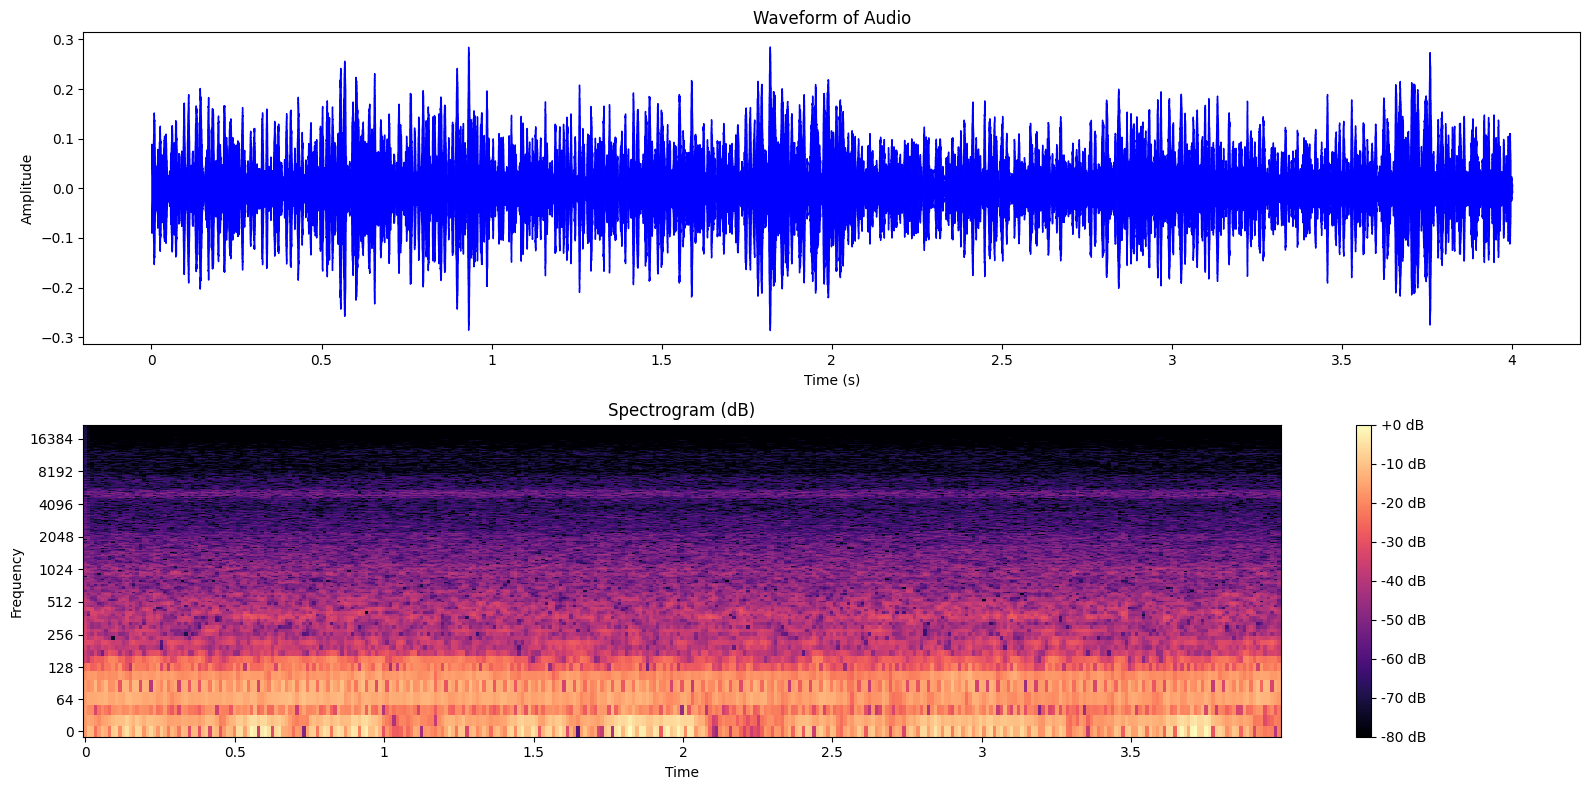

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
> The predicted class of audio is : children_playing
> Random Audio Sample 2 of 2:
> Actual    Class : Children playing
> Predicted Class : Children playing
>> Playing audio from /kaggle/input/urbansound8k/fold5/60846-0-0-0.wav
>  Sample Rate : 44100 Hz


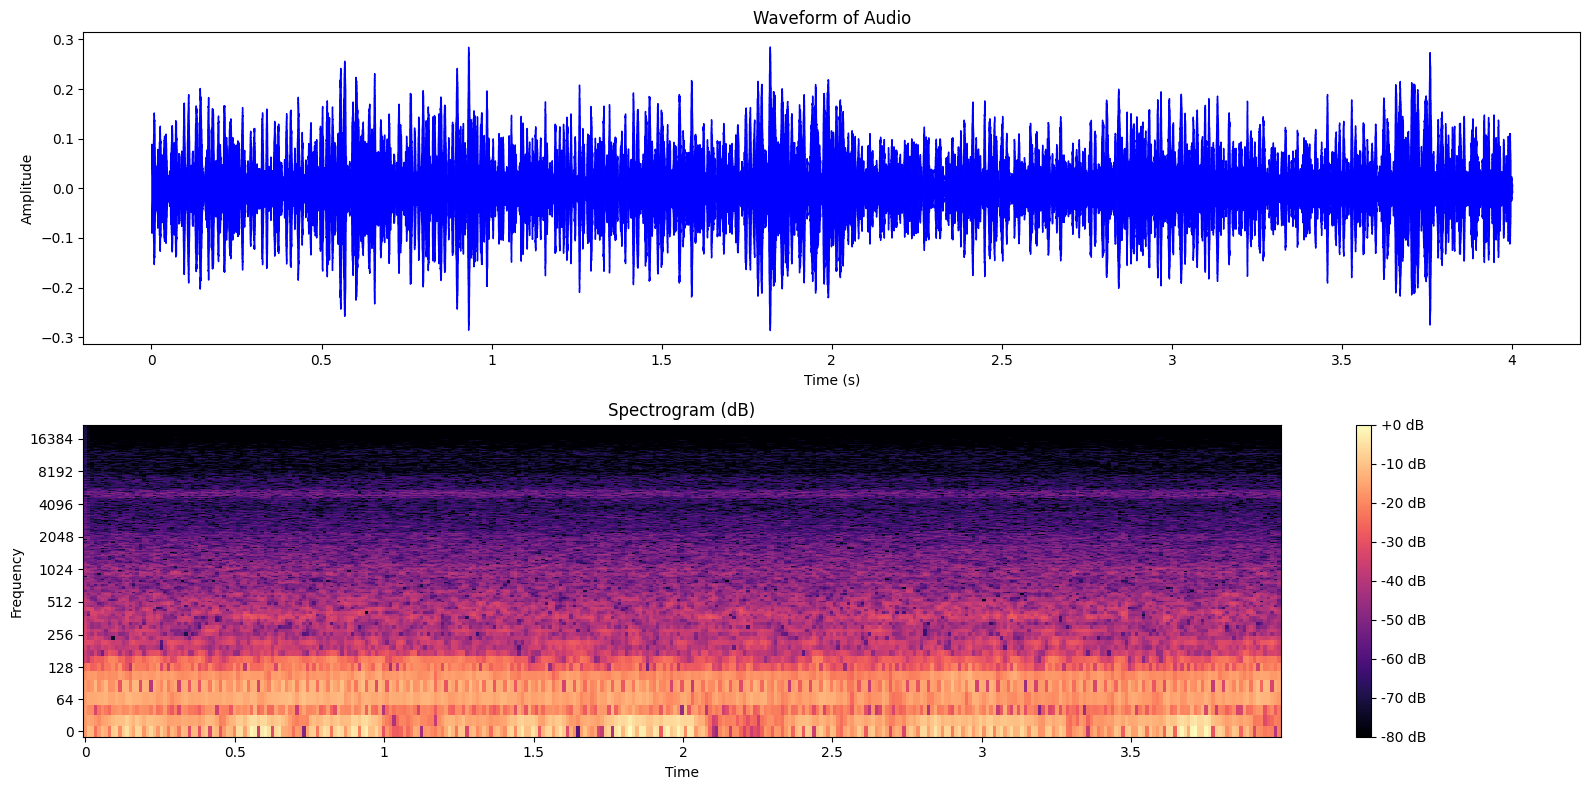

In [60]:
import librosa

# Display the prediction of result
sample_count = 2
samples = audio_df.sample(sample_count)

for i, (index, row) in enumerate(samples.iterrows()):
    class_name = row['class'].replace('_', ' ').capitalize()
    file_name = os.path.join(data_dir, f'fold{row.fold}', row.slice_file_name)
    class_name_pred = label_prediction(cnn_model, le, file_name, n_mfcc, up_width, up_height)

    class_name_pred = class_name_pred.replace('_', ' ').capitalize()
    print(f'> Random Audio Sample {i + 1} of {sample_count}:')
    print(f'> Actual    Class : {class_name}')
    print(f'> Predicted Class : {class_name_pred}')
    play_audio_file(file_path)
    visualize_audio(file_path)

## Step 10 : Save the CNN model

In [62]:
# Save the model
model_dir = '/kaggle/working/'
model_path = os.path.join(model_dir, 'audio_cnn_model.keras')

cnn_model.save(model_path)
print(f'> CNN model saved to {model_path}')

> CNN model saved to /kaggle/working/audio_cnn_model.keras
